In [1]:
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [2]:
infile = '../ChronoLSTM_1d_bin3/DATA_Linear/xvyw1beta9.5gammax1.0gammay1.0epsln1.0sgma1.0A1.0x01.122w0.8B0.15a1.0_h0.01_mix1.txt'
input_x, _=np.loadtxt(infile, unpack=True, max_rows=100000)

In [3]:
device = torch.device("cpu")

In [4]:
num_bins=3
sm_length=20
def running_mean(x, N):
    """Use convolution to do running average."""
    return np.convolve(x, np.ones((N,))/N, mode='valid')

def find_nearest(key_arr, target):
    """key_arr: array-like, storing keys.
       target: the value which we want to be closest to."""
    idx=np.abs(key_arr-target).argmin()
    return idx

def Rm_peaks_steps(traj):
    global threshold
    """
    Remove sudden changes in the trajectory such as peaks and small steps.
    In this method, I used gradient to identify the changes. If two nonzero
    gradients are too close (< threshold), we shall take this range as noise.
    """
    traj=np.array(traj)
    grad_traj=np.gradient(traj) # gradient of trajectory
    idx_grad=np.where(grad_traj!=0)[0]
    threshold=20
    idx0=idx_grad[0]
    for idx in idx_grad:
        window=idx-idx0
        if window <= 1: # neighbor
            continue
        elif window > 1 and window <= threshold:
            traj[idx0:idx0+window//2+1]=traj[idx0]
            traj[idx0+window//2+1:idx+1]=traj[idx+1]
            idx0=idx
        elif window > threshold:
            idx0=idx
    return traj


X = [1.5, 0, -1.5]
input_x = running_mean(input_x, sm_length) # smooothen data.
idx_x = map(lambda x: find_nearest(X, x), input_x) # convert to three bins.

idx_2d=list(idx_x) # list(zip(idx_x, idx_y))
idx_2d = Rm_peaks_steps(idx_2d) # remove peaks and short steps

text = idx_2d


all_combs = [i for i in range(num_bins)]
vocab=sorted(all_combs)

In [5]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])


In [ ]:
class seq_data(Dataset):
    
    def __init__(self, traj, seq_length, shift):
        self.traj = traj
        self.seq_length = seq_length
        self.shift = shift
    
    def __len__(self):
        return self.traj[self.shift:].shape[0]//self.seq_length
    
    def __getitem__(self, idx):
        x = self.traj[:-self.shift][idx:idx+self.seq_length]
        y = self.traj[self.shift:][idx:idx+self.seq_length]
        return x, y


In [6]:
class NLP(nn.Module):
    
    def __init__(self, input_dim, embedding_dim, rnn_units):
        
        super(NLP, self).__init__()
        
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = rnn_units
        
        self.embedding = nn.Embedding(self.input_dim, self.embedding_dim)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, batch_first=True)
        self.linear = nn.Linear(self.hidden_dim, self.input_dim)
    
    def forward(self, input):
        
        batch_size = input.shape[0]
        
        embedding_out = self.embedding(input)
        lstm_in = embedding_out.view(batch_size, input.shape[1], self.embedding_dim)
        lstm_out, hidden = self.lstm(lstm_in)
        y_pred = self.linear(lstm_out)
        
        return y_pred


In [146]:
embedding = nn.Embedding(vocab_size, embedding_dim)
embedding_out = embedding(batch_X_train)
embedding_out.shape

torch.Size([64, 100, 8])

In [147]:
lstm = nn.LSTM(embedding_dim, rnn_units, batch_first=True)
lstm_in = embedding_out.view(batch_X_train.shape[0], batch_X_train.shape[1], embedding_dim)
lstm_out = lstm(lstm_in)
lstm_out[1][0].shape

torch.Size([1, 64, 32])

In [212]:
w_ii, w_if, w_ic, w_io = list(model.modules())[2].weight_ih_l0.chunk(4, 0)
w_hi, w_hf, w_hc, w_ho = list(model.modules())[2].weight_hh_l0.chunk(4, 0)
b_hi, b_hf, b_hc, b_ho = list(model.modules())[2].bias_ih_l0.chunk(4,0)

In [245]:
model.hidden[0][0][0][:10]

tensor([-0.7265,  0.8784, -0.8861, -0.3178,  0.3114, -0.7332,  0.5845, -0.8612,
         0.9074,  0.7950], grad_fn=<SliceBackward>)

In [12]:
EPOCHS = 20
sequence_len = 100
shift=1
batch_size=64

dataset = seq_data(text_as_int, 100, 1)
dataset = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

# Length of the vocabulary in chars
vocab_size = len(vocab)
# The embedding dimension
embedding_dim = 8
# Number of RNN units
rnn_units = 32
# Batch size
batch_size=64

model = NLP(vocab_size, embedding_dim, rnn_units).to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    
    for batch_X_train, batch_Y_train in dataset:
        
        batch_X_train = batch_X_train.to(device)
        batch_Y_train = batch_Y_train.to(device)
        y_pred = model(batch_X_train)
        y=batch_Y_train.to(device)
        
        loss = loss_fn(y_pred.view(-1, vocab_size), y.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(epoch, loss.item())
    

NLP(
  (embedding): Embedding(3, 8)
  (lstm): LSTM(8, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=3, bias=True)
)
0 0.9196396470069885
1 0.6773918867111206
2 0.4450732171535492
3 0.30857041478157043
4 0.22732648253440857
5 0.19294965267181396
6 0.16949014365673065
7 0.1514655202627182
8 0.13920250535011292
9 0.13775059580802917
10 0.12400715798139572
11 0.11666961014270782
12 0.10687491297721863
13 0.11337873339653015
14 0.10833386331796646
15 0.119569331407547
16 0.10686560720205307
17 0.10756060481071472
18 0.1020638570189476
19 0.09924903512001038


# Save weights

In [ ]:
PATH = 'test_weight'
torch.save(model.state_dict(), PATH)

# Reset model to batch_size=1 for prediction

In [ ]:
model = NLP(vocab_size, embedding_dim, rnn_units, 1).to(device)
model.load_state_dict(torch.load(PATH))


# Prediction

In [266]:
def generate_text(start_string):
    
    input_eval = torch.tensor([char2idx[s] for s in start_string], device=device)
    
    text_generated = np.empty(1)
    
    for i in range(1000):
        input_eval = input_eval[np.newaxis, ...] # add a dimension for batch=1.
        prediction=model(input_eval)
        logits=prediction
        p=torch.nn.functional.softmax(logits, dim=-1) # take first batch
        predicted_id=torch.multinomial(p[0,-1], 1)
        
        input_eval = predicted_id
        
        text_generated = np.vstack((text_generated, idx2char[predicted_id].tolist()))

    return text_generated

In [267]:
text = idx_2d[:1000]
prediction=generate_text(text)

In [3]:
infile = 'prediction2'
prediction=np.loadtxt(infile)

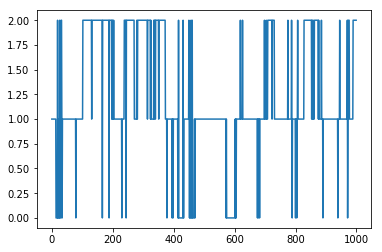

In [268]:
import matplotlib.pyplot as plt
plt.plot(prediction[1:2000])
plt.show()

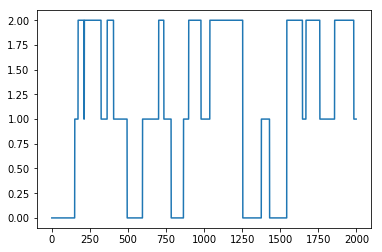

In [16]:
plt.plot(text_as_int[1:2000])

In [7]:
np.where(prediction==0)[0].shape

(10990,)

In [8]:
np.where(prediction==1)[0].shape

(17243,)

In [9]:
np.where(prediction==2)[0].shape

(11767,)